In [36]:
%matplotlib inline
import pandas as pd
import json
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

In [37]:
# path_to_extracted_data = '../results/extracted_data/dataset_results.json'
path_to_extracted_data_v2 = '../results/extracted_data/dataset_results_v2.json'

In [38]:
with open(path_to_extracted_data_v2) as input_json:
    raw_data_v2 = json.load(input_json)




In [39]:

print(len(raw_data_v2))

664208


In [40]:
import importlib
import inspect
def get_classes_names_to_module_names(package_name, modules_list):
    cls_names_to_full_module_names = {}
    for module_name in modules_list:
        full_module_name = '.'.join([package_name, module_name])
        module = importlib.import_module(full_module_name)
        for class_name, obj in inspect.getmembers(module, inspect.isclass):
            cls_names_to_full_module_names[class_name] = full_module_name
    return cls_names_to_full_module_names


SKLEARN_PACKAGE_NAME = 'sklearn'
SKLEARN_MODULES_WITH_MODELS = ['cluster', 'discriminant_analysis', 'ensemble',
                               'kernel_ridge', 'linear_model', 'naive_bayes',
                               'neighbors', 'neural_network', 'semi_supervised',
                               'svm', 'tree']

MODEL_NAMES_TO_MODULE_NAMES = get_classes_names_to_module_names(SKLEARN_PACKAGE_NAME, SKLEARN_MODULES_WITH_MODELS)
ML_MODELS_LIST = list(MODEL_NAMES_TO_MODULE_NAMES.keys())

In [41]:
def only_sklearn_hyperparams(ml_model_name: str, hyperparams):

    module_name = MODEL_NAMES_TO_MODULE_NAMES[ml_model_name]
    module = importlib.import_module(module_name)

    ModelClass = getattr(module, ml_model_name)

    sklearn_hyperparams_set = set(inspect.signature(ModelClass.__init__).parameters.keys())

    return dict(filter(lambda elem: elem[0] in sklearn_hyperparams_set, hyperparams.items()))

In [42]:
ml_model_name = 'LogisticRegression'

In [43]:
samples = []
for entry in raw_data_v2:
    if entry['model']['model_name'] == ml_model_name:
        sample = entry['model']['params']
        filtered_sample = only_sklearn_hyperparams(ml_model_name, sample)
        samples.append(filtered_sample)

In [44]:
df = pd.DataFrame(samples)
print(df.head(10))

  penalty  random_state        C  multi_class solver class_weight  max_iter  \
0      l1      0.000000      NaN          NaN    NaN          NaN       nan   
1      l1           nan 0.100000          NaN    NaN          NaN       nan   
2     NaN           nan      NaN          NaN    NaN          NaN       nan   
3     NaN           nan      NaN          NaN    NaN          NaN       nan   
4     NaN           nan      NaN          NaN    NaN          NaN       nan   
5     NaN           nan      NaN          NaN    NaN          NaN       nan   
6     NaN           nan      NaN          NaN    NaN          NaN       nan   
7      l2      0.000000 0.001000          NaN    NaN          NaN       nan   
8     NaN           nan      NaN  multinomial  lbfgs          NaN       nan   
9     NaN           nan      NaN          NaN    NaN          NaN       nan   

   tol  intercept_scaling  verbose n_jobs  fit_intercept  warm_start  
0  nan                nan      nan    NaN            nan   

In [45]:
print(pd.to_numeric(df['C']).dropna())

1            0.100000
7            0.001000
10      100000.000000
12           1.000000
17           0.001000
             ...     
78313        0.080000
78314        1.000000
78315       13.000000
78348        2.000000
78349        0.001000
Name: C, Length: 16313, dtype: float64


In [46]:
numeric_C = pd.to_numeric(df['C']).dropna()



In [47]:
numeric_C.describe()

count                                         16313.000000
mean    91951204564457807756519172621439714094637305263...
std     30310441462553839215331775746199241798611391182...
min                                               0.000000
25%                                               0.100000
50%                                               1.000000
75%                                             500.000000
max     10000000000000000159028911097599180468360808563...
Name: C, dtype: float64

In [48]:
Q1 = numeric_C.quantile(0.025)
Q3 = numeric_C.quantile(0.975)
IQR = Q3 - Q1

In [49]:
numeric_C

1            0.100000
7            0.001000
10      100000.000000
12           1.000000
17           0.001000
             ...     
78313        0.080000
78314        1.000000
78315       13.000000
78348        2.000000
78349        0.001000
Name: C, Length: 16313, dtype: float64

In [50]:
filtered_C = numeric_C.where(lambda x: ~((x < (Q1 - 1.5 * IQR)) | (x > (Q3 + 1.5 * IQR)))).dropna()

In [51]:
pd.set_option('float_format', '{:f}'.format)
filtered_C.describe()

count        15915.000000
mean      40325966.177345
std      195016354.885524
min              0.000000
25%              0.100000
50%              1.000000
75%            100.000000
max     1000000000.000000
Name: C, dtype: float64

In [52]:
filtered_C.value_counts()

1.000000         3195
0.100000         1874
100.000000       1582
100000.000000    1412
10.000000        1030
                 ... 
120.000000          1
3.125000            1
51.000000           1
0.257576            1
44444.500000        1
Name: C, Length: 404, dtype: int64

In [53]:
def hist_plot_on_interval(values, interval=None):
    if interval is not None:
        values_inside_interval = values.where(lambda x: (x >= interval[0]) & (x <= interval[1])).dropna()
    else:
        values_inside_interval = values
    return sns.histplot(values_inside_interval, bins='doane', kde=True)
    

<AxesSubplot:xlabel='C', ylabel='Count'>

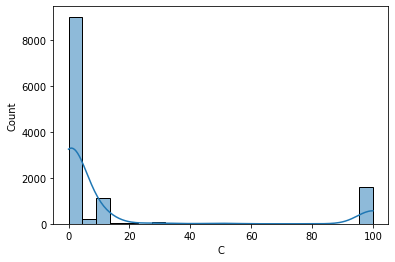

In [55]:
hist_plot_on_interval(filtered_C, (0., 100.))





In [20]:
module_name = MODEL_NAMES_TO_MODULE_NAMES[ml_model_name]
module = importlib.import_module(module_name)
ModelClass = getattr(module, ml_model_name)

sign = inspect.signature(ModelClass.__init__)


In [21]:
sign.parameters['C'].default

1.0

In [22]:
CODE_CELL_HEADER = '#%%'
MD_CELL_HEADER = '#%% md'
RAW_CELL_HEADER = '#%% raw'

def generate_notebook_txt(df, df_row_idx, up_to_cell_number=None, include_non_code_cells=True):
    row = df[df['id'] == df_row_idx]
    repo_id = row['repository_id'].values[0]
    notebook_id = row['notebook_id'].values[0]
    
    only_notebook_cells = df[df['notebook_id'] == notebook_id]
    if not include_non_code_cells:
        only_notebook_cells = only_notebook_cells[only_notebook_cells['cell_type'] == 'code']
    
    result = ''
    for idx, record in only_notebook_cells.sort_values(by=['index']).iterrows():
        record_cell_type = record['cell_type']
        if record_cell_type == 'code':
            result += CODE_CELL_HEADER + '\n'
        elif record_cell_type == 'markdown':
            result += MD_CELL_HEADER + '\n'
        elif record_cell_type == 'raw':
            result += RAW_CELL_HEADER + '\n'
        
        else:
            raise RuntimeError(f'Unknown cell type: {record_cell_type}')
        
        result += record['source'] + '\n'
    
    return result
    

In [80]:

path_to_data = '../../dataset/sklearn_full_cells.csv'

In [81]:
df = pd.read_csv(path_to_data, nrows=500000)

In [82]:
df.head(15)


,Unnamed: 0,id,repository_id,notebook_id,index,cell_type,execution_count,lines,output_formats,source,python,processed,skip,v
0,0,23191644,130180,808459,9,code,13.000000,2,text/html;text/plain,"HTML(data=""""""<iframe width=""854"" height=""480"" ...",True,4,0,808459
1,1,23191643,130180,808459,8,code,12.000000,4,text/html;text/plain,from IPython.display import HTML\n\nHTML(data=...,True,4,0,808459
2,2,23191635,130180,808459,0,code,3.000000,3,NaN,"get_ipython().run_line_magic('pylab', 'inline'...",True,4,0,808459
3,3,23191646,130180,808459,11,code,3.000000,29,text/plain;image/png,from sklearn.datasets import load_iris\nget_ip...,True,4,0,808459
4,4,23191649,130180,808459,14,code,nan,1,NaN,\n,True,4,0,808459
5,5,23191648,130180,808459,13,markdown,nan,1,NaN,"<img src=""http://scikit-learn.sourceforge.net/...",True,4,0,808459
6,6,23191637,130180,808459,2,markdown,nan,1,NaN,<img src='imgs/svm.jpg'>\n,True,4,0,808459
7,7,23191636,130180,808459,1,markdown,nan,1,NaN,"# SVM, support vector machine\n",True,4,0,808459
8,8,23191638,130180,808459,3,markdown,nan,19,NaN,"Дискриминантная функция: $$f(\overline{x}, \ov...",True,4,0,808459
9,9,23191647,130180,808459,12,markdown,nan,2,NaN,SVM можно использовать и для регрессии:\n<a hr...,True,4,0,808459


In [26]:
src23191647 = generate_notebook_txt(df,df_row_idx=23191647)

In [27]:
import os
def save_jupyter_notebook_txt(src, notebook_id, folder):
    fname = '.'.join((str(notebook_id), 'txt'))
    path = os.path.join(folder, fname)
    
    with open(path, 'w') as out_f:
        out_f.write(src)


In [30]:
FOLDER = 'recovered_notebooks'

In [31]:
save_jupyter_notebook_txt(src23191647, notebook_id=808459, folder=FOLDER)

In [32]:
print(src23191647)

#%%
get_ipython().run_line_magic('pylab', 'inline')
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns

#%% md
# SVM, support vector machine

#%% md
<img src='imgs/svm.jpg'>

#%% md
Дискриминантная функция: $$f(\overline{x}, \overline{w}, w_0) = \langle \overline{w}, \overline{x} \rangle - w_0$$

Решающее правило: $$a(\overline{x}, \overline{w}, w_0) = 
\left[ 
  \begin{gathered} 
      1, \langle \overline{w}, \overline{x} \rangle - w_0 > 0,
      \\ 
      0, \langle \overline{w}, \overline{x} \rangle - w_0 \leqslant 0
      \\ 
    \end{gathered} 
\right.$$

Критерий - минимизация эмпирического риска:

$$
  \sum_{i=1}^{l} \Bigl[ a(\overline{x_i}, \overline{w}, w_0) \ne y_i \Bigr] =   \sum_{i=1}^{l} \Bigl[ M_i(\overline{w}, w_0) < 0 \Bigr] \longrightarrow  \displaystyle \min_{\overline{w}, w_0}
$$

где $M_i(\overline{w}, w_0) = ( \langle \overline{w}, \overline{x_i} \rangle - w_0 ) \cdot sign(y_i > 0.5)$

#%% md
<img src="imgs/2.jpg" width=500>
<br><br>
$$
Q(\

In [75]:

class JPT_NB_GRAMMAR:
    
    METADATA_KEY = 'metadata'
    CELLS_KEY = 'cells'
    CELL_TYPE_KEY = 'cell_type'
    EXECUTION_COUNT_KEY = 'execution_count'
    OUTPUTS_KEY = 'outputs'
    SOURCE_KEY = 'source'
    NBFORMAT_KEY = 'nbformat'
    NBFORMAT_MINOR_KEY = 'nbformat_minor'
    
    
    class DEFAULTS:
        DEFAULT_CELL_METADATA = {}
        DEFAULT_EXECUTION_COUNT = None
        DEFAULT_OUTPUTS = []
        
        DEFAULT_NB_METADATA = {
          "kernelspec": {
           "display_name": "Python 3",
           "language": "python",
           "name": "python3"
          },
          "language_info": {
           "codemirror_mode": {
            "name": "ipython",
            "version": 3
           },
           "file_extension": ".py",
           "mimetype": "text/x-python",
           "name": "python",
           "nbconvert_exporter": "python",
           "pygments_lexer": "ipython3",
           "version": "3.7.8"
          }
        }
        DEFAULT_NBFORMAT = 4
        DEFAULT_NBFORMAT_MINOR = 1


In [76]:
JPT_NB_GRAMMAR.DEFAULTS.DEFAULT_NB_METADATA

{'kernelspec': {'display_name': 'Python 3',
  'language': 'python',
  'name': 'python3'},
 'language_info': {'codemirror_mode': {'name': 'ipython', 'version': 3},
  'file_extension': '.py',
  'mimetype': 'text/x-python',
  'name': 'python',
  'nbconvert_exporter': 'python',
  'pygments_lexer': 'ipython3',
  'version': '3.7.8'}}

In [77]:
def generate_notebook_ipynb(df, df_row_idx, up_to_cell_number=None, include_non_code_cells=True):
    row = df[df['id'] == df_row_idx]
    repo_id = row['repository_id'].values[0]
    notebook_id = row['notebook_id'].values[0]
    
    only_notebook_cells = df[df['notebook_id'] == notebook_id]
    if not include_non_code_cells:
        only_notebook_cells = only_notebook_cells[only_notebook_cells['cell_type'] == 'code']
    
    result = {}
    
    result[JPT_NB_GRAMMAR.METADATA_KEY] = JPT_NB_GRAMMAR.DEFAULTS.DEFAULT_NB_METADATA
    result[JPT_NB_GRAMMAR.NBFORMAT_KEY] = JPT_NB_GRAMMAR.DEFAULTS.DEFAULT_NBFORMAT
    result[JPT_NB_GRAMMAR.NBFORMAT_MINOR_KEY] = JPT_NB_GRAMMAR.DEFAULTS.DEFAULT_NBFORMAT_MINOR
    
    result[JPT_NB_GRAMMAR.CELLS_KEY] = []
    
    for idx, record in only_notebook_cells.sort_values(by=['index']).iterrows():
        cell = {}
        cell[JPT_NB_GRAMMAR.CELL_TYPE_KEY] = record['cell_type']
        cell[JPT_NB_GRAMMAR.EXECUTION_COUNT_KEY] = JPT_NB_GRAMMAR.DEFAULTS.DEFAULT_EXECUTION_COUNT
        cell[JPT_NB_GRAMMAR.METADATA_KEY] = JPT_NB_GRAMMAR.DEFAULTS.DEFAULT_CELL_METADATA
        cell[JPT_NB_GRAMMAR.OUTPUTS_KEY] = JPT_NB_GRAMMAR.DEFAULTS.DEFAULT_OUTPUTS
        cell[JPT_NB_GRAMMAR.SOURCE_KEY] = record['source']
        
        result[JPT_NB_GRAMMAR.CELLS_KEY].append(cell)
    
    return result

In [83]:
generate_notebook_ipynb(df,df_row_idx=23191647)

{'metadata': {'kernelspec': {'display_name': 'Python 3',
   'language': 'python',
   'name': 'python3'},
  'language_info': {'codemirror_mode': {'name': 'ipython', 'version': 3},
   'file_extension': '.py',
   'mimetype': 'text/x-python',
   'name': 'python',
   'nbconvert_exporter': 'python',
   'pygments_lexer': 'ipython3',
   'version': '3.7.8'}},
 'nbformat': 4,
 'nbformat_minor': 1,
 'cells': [{'cell_type': 'code',
   'execution_count': None,
   'metadata': {},
   'outputs': [],
   'source': "get_ipython().run_line_magic('pylab', 'inline')\nget_ipython().run_line_magic('matplotlib', 'inline')\nimport seaborn as sns\n"},
  {'cell_type': 'markdown',
   'execution_count': None,
   'metadata': {},
   'outputs': [],
   'source': '# SVM, support vector machine\n'},
  {'cell_type': 'markdown',
   'execution_count': None,
   'metadata': {},
   'outputs': [],
   'source': "<img src='imgs/svm.jpg'>\n"},
  {'cell_type': 'markdown',
   'execution_count': None,
   'metadata': {},
   'outputs':

In [89]:
def save_jupyter_notebook_ipynb(raw_json, notebook_id, folder):
    fname = '.'.join((str(notebook_id), 'ipynb'))
    path = os.path.join(folder, fname)
    
    with open(path, 'w') as out_f:
        json.dump(raw_json, out_f)

In [90]:
save_jupyter_notebook_ipynb(raw_json=generate_notebook_ipynb(df,df_row_idx=23191647),
                            notebook_id=808459,
                            folder=FOLDER)